In [1]:
from sklearn.metrics import mean_squared_error, brier_score_loss, f1_score
from ff_custom_scripts import *
import shap
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier, CatBoostRegressor


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test,leaderboard,holdout]) 

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1210) (294, 1210) (530, 1210) (1111, 1210)


In [3]:
def run_model(train, test, target='gpa', classifier=False):

    catcols = train.select_dtypes(include=['category']).columns
    train[catcols] = train[catcols].astype(str)
    test[catcols] = test[catcols].astype(str)

    X_train, y_train = prepare_data(train, target)
    X_test, y_test = prepare_data(test, target)

    print(X_train.shape, y_train.shape)

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    ordinal_features = cols_per_type(X_train, 'Ordered Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    categorical_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    print(f'N. of ordinal features: {len(ordinal_features)}')
    
    iter = 20_000

    if classifier:
        catboost = CatBoostClassifier(
          thread_count=-1, cat_features=categorical_features, verbose=0,random_seed=88)
    else:
        
        catboost = CatBoostRegressor(thread_count=-1, cat_features=categorical_features, random_seed=123,
                                     iterations=iter, early_stopping_rounds=iter*0.1,verbose=10)

    model = catboost.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)

    return model


def mse_error(model, data, target='gpa'):
    X, y = prepare_data(data, target)
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

# Eviction

In [4]:
model_eviction = run_model(train,test,target='eviction', classifier=True)

(1167, 1204) (1167,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


In [5]:
score_model(model_eviction, target='eviction',test=test, leaderboard=leaderboard, classifier=True, holdout=holdout)

Scores without threshold adjusment
Test Brier: 0.0514
Test F1: 0.0000
Leaderboard Brier: 0.0566
Number of positive predictions: 0.0
>> Leaderboard F1: 0.0000
Leaderboard Accuracy: 0.9434
Leaderboard Recall: 0.0000
Holdout Brier: 0.0589
Holdout F1: 0.0000


Scores with threshold adjusment


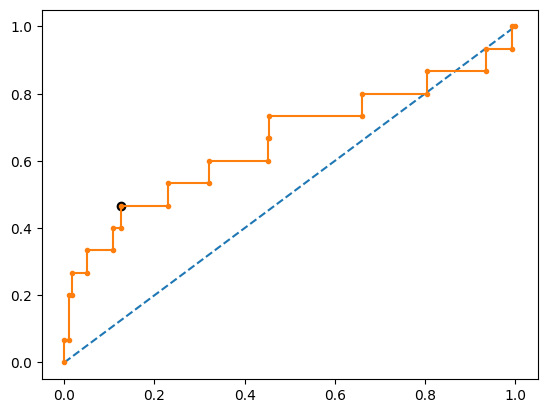

Threshold=0.073, FPR=0.126, TPR=0.467
Test brier: 0.151
Test F1: 0.214
Leaderboard Brier: 0.192
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89       500
         1.0       0.12      0.40      0.19        30

    accuracy                           0.81       530
   macro avg       0.54      0.62      0.54       530
weighted avg       0.91      0.81      0.85       530

Leaderboard F1: 0.190
Holdout Brier: 0.158
Holdout F1: 0.179


In [14]:
score_classifier(model_eviction, target='eviction', holdout=holdout, test=test,leaderboard=leaderboard)

# Shap values with all data

In [7]:
final_model = run_model(alldata,leaderboard,target='eviction', classifier=True)

(3092, 1204) (3092,)
N. of numerical features: 106
N. of binary features: 570
N. of categorical features: 114
N. of ordinal features: 414


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


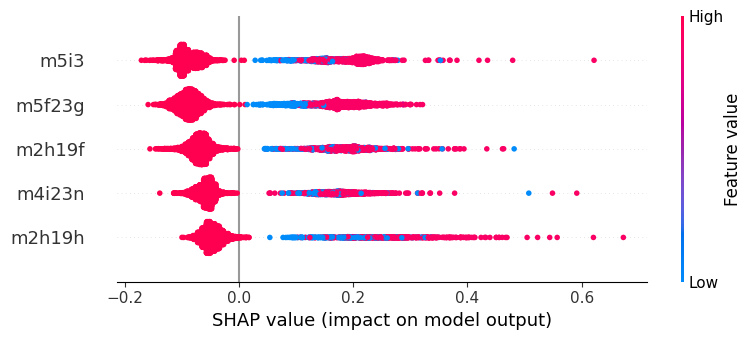

In [8]:
# plot shap values of final model
X, y = prepare_data(alldata, 'eviction')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

top_features = 5

shap.summary_plot(shap_values, X, max_display=top_features)

# feat names of top 10 features
top = X.columns[np.argsort(-np.abs(shap_values).mean(0))[:top_features]]

In [9]:
feat_2id(top).to_csv('../metadata/topfeat_eviction.csv')
feat_2id(top)

,varlab
m5i3,I3. Have completed training programs or years ...
m5f23g,F23G. Borrowed money from friends/family to he...
m2h19f,"In past year, did you-Not pay full gas/oil/ele..."
m4i23n,"In past year, phone service disconnected b/c w..."
m2h19h,"In past year, did your-Telephone service get d..."


# EDA on important variables

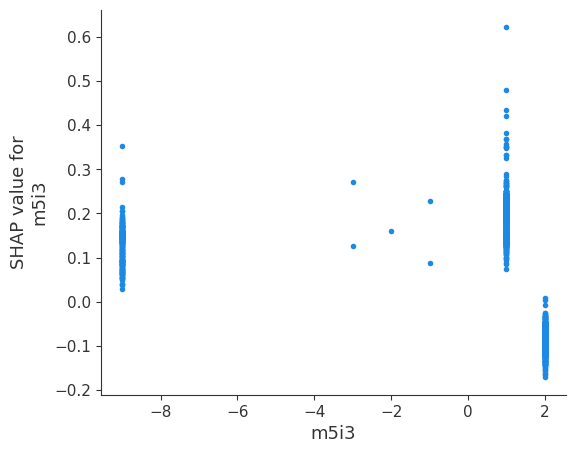

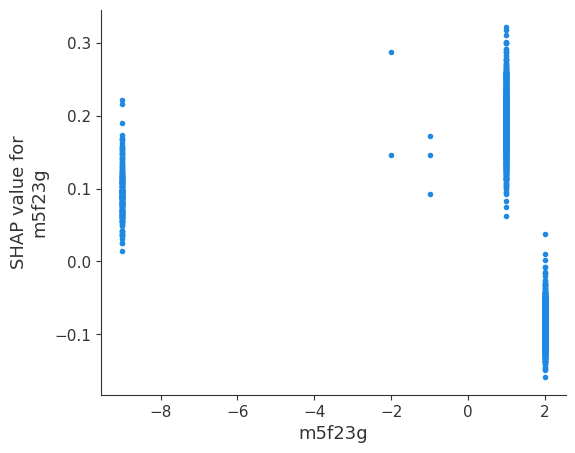

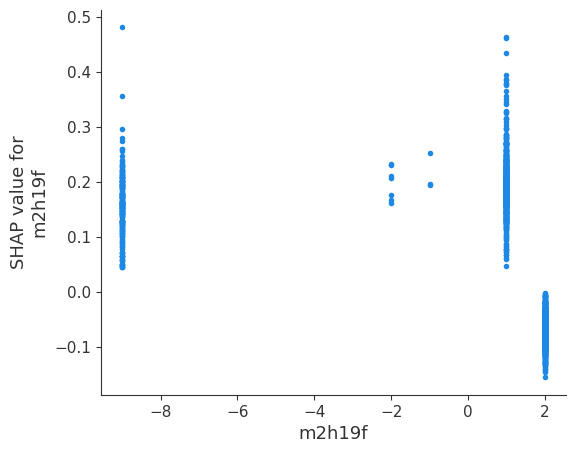

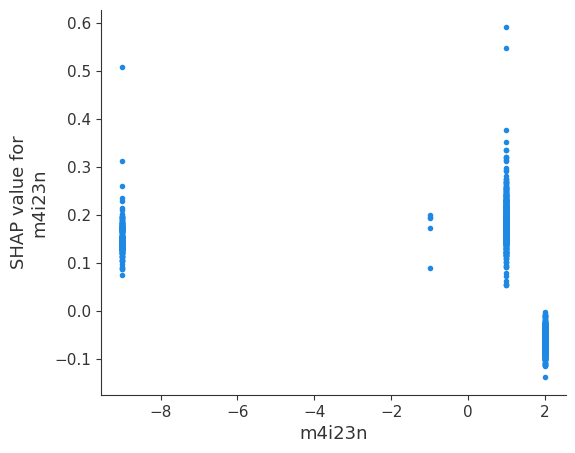

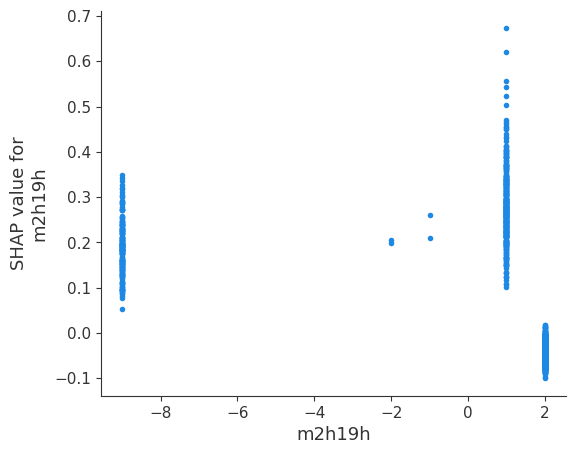

In [10]:
# dependence plots of m4k13
for feat in top:
    shap.dependence_plot(feat, shap_values, X, interaction_index=None)

In [11]:
alldata.m4k13.value_counts(normalize=True)

 0.000000        0.338268
-9.000000        0.076279
-6.000000        0.026392
-1.000000        0.019955
-2.000000        0.016736
                   ...   
 4780.335894     0.000322
 42808.666337    0.000322
 49863.679552    0.000322
 32940.005054    0.000322
 44088.183727    0.000322
Name: m4k13, Length: 1628, dtype: float64

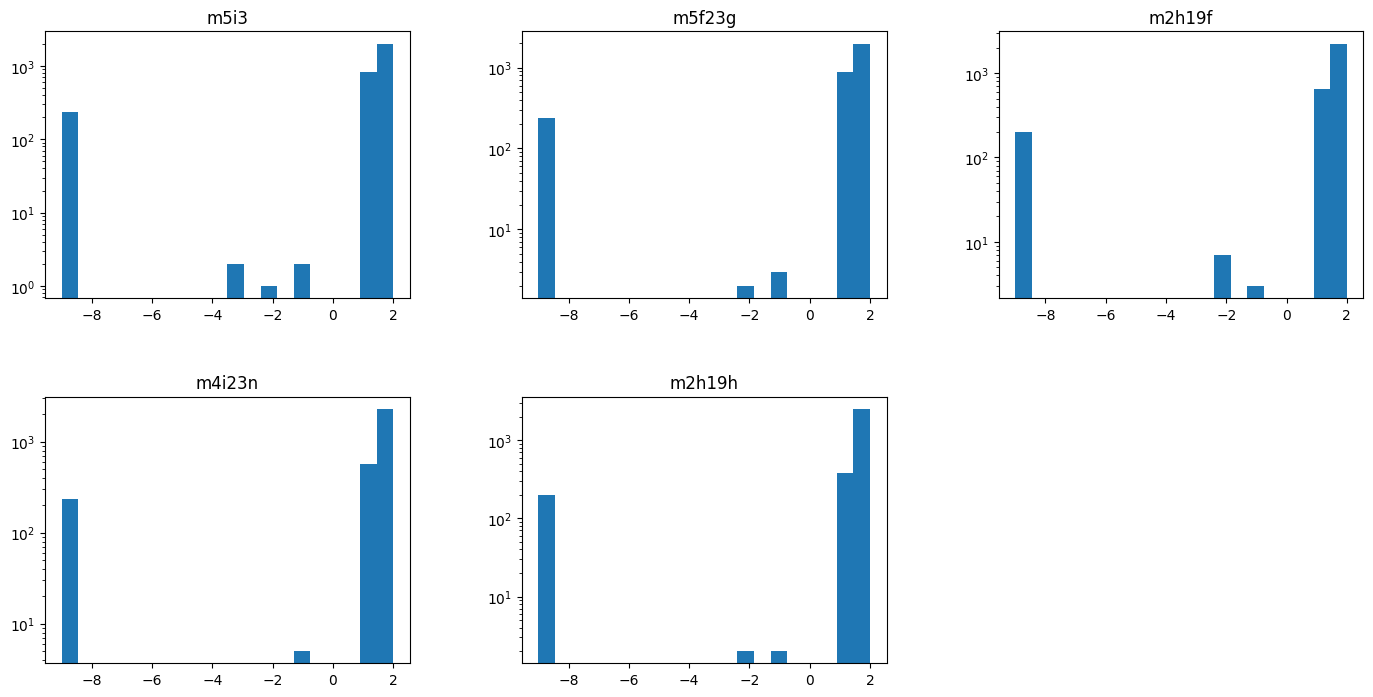

In [12]:
import matplotlib.pyplot as plt

top_features = feat_2id(top).index.values
num_features = len(top_features)
num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
fig.tight_layout(pad=5.0)

for idx, var in enumerate(top_features):
    row = idx // num_cols
    col = idx % num_cols
    
    axes[row, col].set_title(var)
    axes[row, col].hist(alldata[var], bins=20, log=True)
    
# Remove the last (unused) subplot
axes[num_rows - 1, num_cols - 1].axis("off")

plt.show()


In [13]:
alldata.m4k13

challengeID
958      6141.967102
983     30241.991157
3591       -6.000000
3684     2222.947850
3554        0.000000
            ...     
4231        0.000000
4233       -6.000000
4234    29396.760976
4237    44088.183727
4242       -6.000000
Name: m4k13, Length: 3107, dtype: float64